In [9]:
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
from main import Lorenz
import random
from sklearn.metrics import mean_squared_error as RMSE
from sklearn.svm import SVR
from dim_work_version import delay_vector
import numpy as np
from sklearn import preprocessing

In [10]:
def generate_Z(mu, z_0, N):
    Z = [0] * N
    Z[0] = z_0
    for i in range(1, N):
        Z[i] = mu * Z[i - 1] * (1 - Z[i - 1])
    return Z


def preprocess_intervals(intervals):
    for y in intervals:
        tmp1 = np.log(y[0])
        tmp2 = np.log(y[1])
        y[0] = tmp1
        y[1] = tmp2
    return intervals


def inverse_transform_x_final(x_final):
    for i in range(len(x_final)):
        x_final[i] = np.exp(x_final[i])
    return x_final

In [11]:
discretizer = KBinsDiscretizer(n_bins=1000, encode='ordinal', strategy='uniform')
normalize_coef = 0


def preprocess_data(data):
    data = data.reshape((len(data), 1))

    global discretizer, normalize_coef
    data_discr = discretizer.fit_transform(data)
    normalize_coef = max(data_discr)

    preprocessed_data = preprocessing.normalize(data_discr, axis=0, norm='max')
    preprocessed_data = preprocessed_data.reshape(len(preprocessed_data), )
    return preprocessed_data

In [12]:
def recovery(data):
    global discretizer
    for i in range(len(data)):
        data[i] *= normalize_coef
    data = data.reshape(len(data), 1)
    data = discretizer.inverse_transform(data)
    recovered_data = data.reshape(len(data), )
    return recovered_data


In [13]:
def compute_f(x):
    gamma = np.exp(x[2])
    C = np.exp(x[0])
    epsilon = np.exp(x[1])
    regr = SVR(kernel='rbf', gamma=gamma, C=C, epsilon=epsilon)
    regr.fit(X_train, train)
    x_pred = regr.predict(X_train)
    x_true = train
    return RMSE(x_true, x_pred) ** (1 / 2)

In [14]:
def step1():
    f_final, x_final = 0, [0] * 3
    for i in range(len(x_final)):
        z_i = random.choice(arr_Z)
        a = intervals[i][0]
        b = intervals[i][1]
        x_final[i] = a + (b - a) * z_i
    f_final = compute_f(x_final)
    return x_final, f_final


def step_2(z_i, intervals):
    arr = []
    for i in range(len(intervals)):
        a = intervals[i][0]
        b = intervals[i][1]
        arr.append(a + (b - a) * z_i)
    return arr


def step_3(x, x_final, f_final, A, time):
    f_tmp = compute_f(x)
    if f_tmp <= f_final:
        f_final = f_tmp
        x_final = x
        time += 1
    if time > A:
        return [True, x_final, f_final, time]
    else:
        return [False, x_final, f_final, time]


def chaos(A=10, M=10 ** 4, time=0):
    x_final, f_final = step1()
    flag = False
    K = 0
    J_end = 10e-4

    while not flag:
        z_i = random.choice(arr_Z)
        x = step_2(z_i, intervals)
        arr = step_3(x, x_final, f_final, A, time)
        flag, x_final, f_final, time = arr[0], arr[1], arr[2], arr[3]

        if K > M or f_final < J_end:
            return inverse_transform_x_final(x_final), f_final
        else:
            K += 1
            for i in range(len(intervals)):
                a = intervals[i][0]
                b = intervals[i][1]
                intervals[i][0] = x_final[i] - (b - a) / (K + 1)
                intervals[i][1] = x_final[i] + (b - a) / (K + 1)
                if intervals[i][0] < a:
                    intervals[i][0] = a
                if intervals[i][1] > b:
                    intervals[i][1] = b

    return inverse_transform_x_final(x_final), f_final


In [15]:
# подготовительные вычисления

import mutual_info
from dim_work_version import false_nearest_neighbors

N = 1500
arr, t = Lorenz.solve(10**4)  # решаем систему ЛОренца
tau = mutual_info.find_tau(arr[0])      # вычисляем шаг задержки tau
dim = false_nearest_neighbors(arr[0], tau, 3)   # вычисляем размерность вложенного пространства
intervals = preprocess_intervals(
    [[2 ** (-5), 2 ** 15], [2 ** (-12), 1], [2 ** (-15), 2 ** 5]])  # нормализованные интервалы для искомых констант
arr_Z = generate_Z(3.6, 0.2, N)

data = arr[0][5000:7500]  # берем 2500 точек координты х
data = preprocess_data(data)
train = data[:N]
test = data[N:N+1000]
X_train = delay_vector(train, tau, dim)
train = train[:-(dim - 1) * tau]
X_test = delay_vector(test, tau, dim)
test = test[:-(dim - 1) * tau]

In [16]:
constants, rmse = chaos()
print('получившиеся константы', constants)
print('RMSE получилось на тренировочных данных', rmse)
model = SVR(kernel='rbf', gamma=constants[2], C=constants[0], epsilon=constants[1])
model.fit(X_train, train)
x_pred = model.predict(X_test)
x_true = test

print("RMSE на тестовых данных", RMSE(x_true, x_pred) ** (1 / 2))

получившиеся константы [3.3471336100509372, 0.004032123895750401, 0.003268685166065371]
RMSE получилось на тренировочных данных 0.0025085633678673903
RMSE на тестовых данных 0.002497399320408034


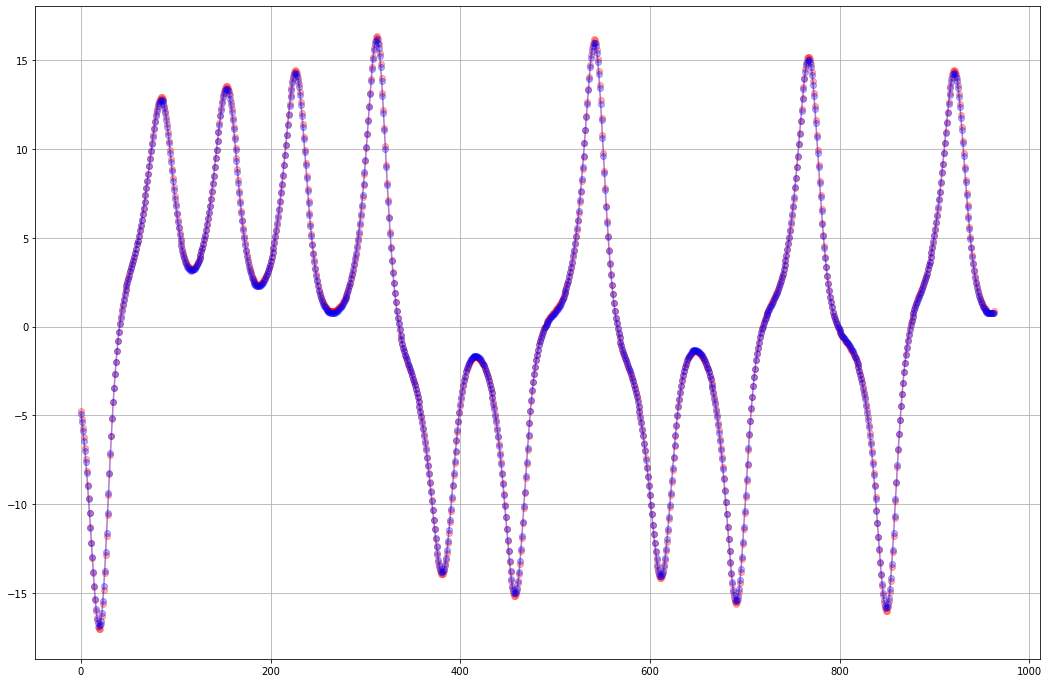

In [17]:
y = recovery(test)
x = [i for i in range(0, len(y))]
y_pred = recovery(x_pred)

plt.figure(figsize=(18, 12))
plt.plot(x, y, 'o-r', alpha=0.3)
plt.plot(x, y_pred,'o-r', alpha = 0.3, c = 'b')
plt.grid()
